Notebook imitant:
    https://towardsdatascience.com/causal-machine-learning-for-econometrics-causal-forests-5ab3aec825a7

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 

In [3]:
#Read main data to DataFrame
df = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

In [4]:
# "hogarid_old","cp_old","unique_05", "cpmom_06" seran usats com a index
df_out=df[["a5sscore_i_06","a6smemory_p1_06","a6smemory_p2_06","a7a_delay_06","a7b_delay_06",
        "a7c_delay_06","a7d_delay_06","a9sgrossmotor_06","height_06","weight_06","z_tvip_06","z_social_06",
        "z_language_06","z_finmotor_06","z_memory_06","z_grmotor_06","z_legmotor_06","z_behavior_06","z_height_06",
        "z_weight_06","z_all_06"]]


In [7]:
df_out.isna().sum().sort_values()

z_all_06            1185
a7a_delay_06        1200
z_social_06         1204
a7b_delay_06        1220
z_language_06       1224
a7c_delay_06        1242
z_finmotor_06       1246
a7d_delay_06        1254
z_grmotor_06        1258
z_height_06         1429
height_06           1429
weight_06           1429
z_weight_06         1429
a9sgrossmotor_06    2656
a6smemory_p1_06     2669
z_legmotor_06       2673
a5sscore_i_06       2679
z_memory_06         2684
z_tvip_06           2694
z_behavior_06       2891
a6smemory_p2_06     3141
dtype: int64

# Income variables

In [270]:
df1=df[["hogarid_old","cp_old","unique_05","s1age_head_05","s1hhsize_05","s1hhsz_undr5_05","s1hhsz_5_14_05",
        "s1hhsz_15_24_05","s1hhsz_25_64_05","s1hhsz_65plus_05","s1male_head_05","s2mother_inhs_05","s3ap5_rooms_h_05",
        "s3ap23_stime_h_05","s3ap24_htime_h_05","s3ap25_hqtime_h_05","s3atoilet_hh_05","s3awater_access_hh_05",
        "s3aelectric_hh_05","s4p6_vitamina_i_05","s4p7_parasite_i_05","s11ownland_hh_05","cons_food_pc_05","cons_tot_pc_05",
        "tvip_05","height_05","a10whz_05","weight_05","itt_i","itt_all_i","yrsedfath","age_transfer","bweight",
        "s4p7_parasite_i_06","cpmom_06","T","male","TREAT1","TREAT2","TREAT3","TREAT4","ed_mom","MUN1","MUN2","MUN3","MUN4",
        "MUN5","MUN6","com_haz_05","com_waz_05","com_tvip_05","com_control_05","com_vit_05","com_deworm_05","com_notvip",
        "sample06","vitamiron_06",#"weighted_05",
        "propfood_05","prstap_f_05","pranimalprot_f_05","prfruitveg_f_05"]]

In [271]:
df1.rename(columns = {'T':'tr'}, inplace = True)

###  NaNs

In [272]:
df1.isnull().sum(axis=1).value_counts()

1     1357
11     910
0      631
8      427
2      243
5      212
4      133
3      130
12     129
7      112
9       66
6       59
10      48
55      32
56       7
54       7
14       6
13       2
dtype: int64

In [273]:
#fem una copia del df
def copy_df(df):
   return df.copy()

In [274]:
#eliminem individus amb >delta*100% columnes buides
def drop_ind_missing(df, delta):
    thresh = len(df.columns)*delta
    df.dropna(axis=0, thresh=thresh, inplace=True)
    return df

In [275]:
#eliminem individus amb age transfer<age
def drop_out_missing(df, age=-11):
    nan_rows=df[df.age_transfer<age].index
    df.drop(nan_rows, inplace=True)
    return df

In [276]:
#categorical to ordinal
def ordinal(df, cols):
    enc = OrdinalEncoder()
    enc.fit(df[cols])
    df[cols] = enc.transform(df[cols])
    
    return df

In [277]:
#imputem NaNs

#imputem mitjanes
def mean_imputer(df, cols):
    for col in cols:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

#imputem el valor més frequent de la columna dintre el hh
def hh_mf_imputer(df,cols):
    index=df.index
    for col in cols:
        col_hh=[df[df.hogarid_old==familia][[col,"age_transfer"]].sort_values(by=['age_transfer'])[col]
                .values for familia in df.hogarid_old]
        for i in range(len(index)):
               if np.isnan(df[col][index[i]]):
                    non_nan_len=np.count_nonzero(~np.isnan(col_hh[i]))
                    if(non_nan_len!=0):
                        vals,counts = np.unique(col_hh[i], return_counts=True)
                        ind = np.argmax(counts)
                        df.loc[index[i],col]=vals[ind]
    return df             
                            
                        

In [278]:
#eliminem outliers

def outlier_removal(df, cols):
    outlier_threshold = []
    for col in cols:
            q3 = np.nanpercentile(df[col], 75)
            q1 = np.nanpercentile(df[col], 25)
            iqr = q3 - q1
            out_low = q1 - 3*iqr
            out_high = q3 + 3*iqr
            outlier_threshold.append([out_low, out_high])
    outliers_indexs=[]
    for col,k in zip(cols,range(len(cols))):
        #outliers_indexs_in_col=[]
        for i in df[col].index:
            if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
                outliers_indexs.append(i)
        #outliers_indexs.append(outliers_indexs_in_col)
    return df.drop(list(set(outliers_indexs)), axis=0)

In [279]:
def normalize(df, cols):
    Nscaler = MinMaxScaler()

    Nscaler.fit(df[cols])
    df[cols] = Nscaler.transform(df[cols])
    
    return df

def standardize(df, cols):
    Sscaler = StandardScaler()

    Sscaler.fit(df[cols])
    df[cols] = Sscaler.transform(df[cols])
    
    return df

In [280]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

mean_cols=["bweight", "tvip_05", "height_05", "a10whz_05", "weight_05"]
hh_mf_cols=["s1age_head_05","s1hhsize_05","s1hhsz_undr5_05","s1hhsz_5_14_05","s1hhsz_15_24_05","s1hhsz_25_64_05",
            "s1hhsz_65plus_05","s1male_head_05","s2mother_inhs_05","s3ap5_rooms_h_05","s3atoilet_hh_05",
            "s3awater_access_hh_05","s3aelectric_hh_05","s11ownland_hh_05","s4p7_parasite_i_06","ed_mom","vitamiron_06",
           "s4p6_vitamina_i_05", "s4p7_parasite_i_05", "cons_food_pc_05", "yrsedfath", "propfood_05", "prstap_f_05"
            ,  "pranimalprot_f_05",  "prfruitveg_f_05"]

categorical_cols=df1.select_dtypes(exclude=["number","bool_","object_"]).columns
outlier_cols=["pranimalprot_f_05", "bweight", "prfruitveg_f_05"]

normal_cols =["height_05","a10whz_05","weight_05","com_haz_05","com_waz_05"]

Nnormal_cols = ['s1age_head_05', 's3ap23_stime_h_05', 's3ap24_htime_h_05', 's3ap25_hqtime_h_05', 'cons_food_pc_05', 
                'cons_tot_pc_05', 'tvip_05', 'yrsedfath','age_transfer', 'bweight', 'ed_mom', 'com_tvip_05', 'com_control_05']


cleaned_df=(df1.pipe(copy_df)
            .pipe(drop_ind_missing, 0.8)
            .pipe(drop_out_missing)
            .pipe(ordinal, categorical_cols)
            .pipe(hh_mf_imputer, hh_mf_cols)
            .pipe(mean_imputer, mean_cols+hh_mf_cols)
            .pipe(outlier_removal, outlier_cols) #outliers
            .pipe(standardize, normal_cols)) #estandaritzacio
            #.pipe(normalize, Nnormal_cols)) #normalitzacio
                         

In [281]:
categorical_cols

Index(['s1male_head_05', 's3atoilet_hh_05', 's3awater_access_hh_05',
       's3aelectric_hh_05', 's4p6_vitamina_i_05', 's4p7_parasite_i_05',
       's11ownland_hh_05', 'itt_i', 'itt_all_i', 's4p7_parasite_i_06'],
      dtype='object')

In [282]:
treatment = 'tr'
outcome = 'z_all_06'
covariates = ["s1age_head_05","s1hhsize_05","s1hhsz_undr5_05","s1hhsz_5_14_05",
        "s1hhsz_15_24_05","s1hhsz_25_64_05","s1hhsz_65plus_05","s1male_head_05","s2mother_inhs_05","s3ap5_rooms_h_05",
        "s3ap23_stime_h_05","s3ap24_htime_h_05","s3ap25_hqtime_h_05","s3atoilet_hh_05","s3awater_access_hh_05",
        "s3aelectric_hh_05","s4p6_vitamina_i_05","s4p7_parasite_i_05","s11ownland_hh_05","cons_food_pc_05","cons_tot_pc_05",
        "tvip_05","height_05","a10whz_05","weight_05","itt_i","itt_all_i","yrsedfath","age_transfer","bweight",
        "s4p7_parasite_i_06","male","TREAT1","TREAT2","TREAT3","TREAT4","ed_mom","MUN1","MUN2","MUN3","MUN4",
        "MUN5","MUN6","com_haz_05","com_waz_05","com_tvip_05","com_control_05","com_vit_05","com_deworm_05","com_notvip",
        "sample06","vitamiron_06",
        "propfood_05","prstap_f_05","pranimalprot_f_05","prfruitveg_f_05"]

In [283]:
cleaned_df.drop(cleaned_df[df_out.iloc[cleaned_df.index].z_all_06.isna()].index, axis=0, inplace=True)

In [284]:
cleaned_df["z_all_06"]=df_out.iloc[cleaned_df.index].z_all_06

In [285]:
cp_cols=["hogarid_old","cp_old","unique_05", "cpmom_06"]

In [286]:
cleaned_df.drop(cp_cols, axis=1, inplace=True)

In [22]:
from sklearn.model_selection import train_test_split
# split data into train and test sets 
train, test = train_test_split(cleaned_df, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome]
T = train[treatment]
X = train[covariates]
W = None
X_test = test[covariates]

In [ ]:
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV

# set parameters for causal forest 
causal_forest1 = CausalForestDML(criterion='het', 
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(),
                                )
                      
# fit train data to causal forest model 
causal_forest1.fit(Y, T, X=X, W=W)
# estimate the CATE with the test set 
causal_forest1.const_marginal_ate(X_test)

In [ ]:
a=causal_forest1.effect(X)

Mirem de interpretar i identificar subgrups a través de les eines d'interpretació de econML. Primer fem un decision tree naive, sembla que fa el mateix que SingleTreeCateInterpreter. Després provem aquest (SingleTreeCateInterpreter) i llavors SingleTreePolicyInterpreter

In [ ]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(max_depth=4).fit(X,a)
sklearn.tree.export_graphviz(reg, 'test.dot')

In [ ]:
import graphviz
import os 
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz/bin/'
# DOT data
dot_data = sklearn.tree.export_graphviz(reg, out_file=None, 
                                feature_names=covariates) 
                                #class_names=iris.target_names,
                                #filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph


In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import LinearDML

intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
# We interpret the CATE model's behavior based on the features used for heterogeneity
intrp.interpret(causal_forest1, X)
# Plot the tree
intrp.plot(feature_names=covariates, fontsize=12)
intrp.plot()


In [ ]:
intrp.render("prova1", feature_names=covariates)

In [ ]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

intrp = SingleTreePolicyInterpreter(risk_level=None, max_depth=2, min_samples_leaf=1,min_impurity_decrease=.001)
intrp.interpret(causal_forest1, X, sample_treatment_costs=0.02)


In [ ]:
intrp.render("prova2", feature_names=covariates)

### SHAP

In [ ]:
pd.Series(causal_forest1.feature_importances_,index=causal_forest1.cate_feature_names()).sort_values()

In [ ]:
import shap
from econml.dml import CausalForestDML

# fit causal forest with default parameters 
causal_forest = CausalForestDML()
causal_forest.fit(Y, T, X=X, W=W)

# calculate shap values of causal forest model 
shap_values = causal_forest.shap_values(X)


In [ ]:

# plot shap values 
shap.summary_plot(shap_values['z_all_06']["tr"])

### ITE

-Regressio
-Random forest
-XGBoost

In [23]:
covariates+ ["tr"]

['s1age_head_05',
 's1hhsize_05',
 's1hhsz_undr5_05',
 's1hhsz_5_14_05',
 's1hhsz_15_24_05',
 's1hhsz_25_64_05',
 's1hhsz_65plus_05',
 's1male_head_05',
 's2mother_inhs_05',
 's3ap5_rooms_h_05',
 's3ap23_stime_h_05',
 's3ap24_htime_h_05',
 's3ap25_hqtime_h_05',
 's3atoilet_hh_05',
 's3awater_access_hh_05',
 's3aelectric_hh_05',
 's4p6_vitamina_i_05',
 's4p7_parasite_i_05',
 's11ownland_hh_05',
 'cons_food_pc_05',
 'cons_tot_pc_05',
 'tvip_05',
 'height_05',
 'a10whz_05',
 'weight_05',
 'itt_i',
 'itt_all_i',
 'yrsedfath',
 'age_transfer',
 'bweight',
 's4p7_parasite_i_06',
 'male',
 'TREAT1',
 'TREAT2',
 'TREAT3',
 'TREAT4',
 'ed_mom',
 'MUN1',
 'MUN2',
 'MUN3',
 'MUN4',
 'MUN5',
 'MUN6',
 'com_haz_05',
 'com_waz_05',
 'com_tvip_05',
 'com_control_05',
 'com_vit_05',
 'com_deworm_05',
 'com_notvip',
 'sample06',
 'vitamiron_06',
 'propfood_05',
 'prstap_f_05',
 'pranimalprot_f_05',
 'prfruitveg_f_05',
 'tr']

In [24]:
from sklearn.model_selection import train_test_split
# split data into train and test sets 
train, test = train_test_split(cleaned_df, test_size=0.33)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
y_train = train[outcome]
X_train = train[covariates+["tr"]]

X_test = test[covariates+["tr"]]
y_test =  test[outcome]

In [25]:
def display_scores(scores,model_name = None):
    if(model_name):
        print("----",model_name,"----")
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [26]:
sorted(sklearn.metrics.SCORERS.keys())

NameError: name 'sklearn' is not defined

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

forest_reg = RandomForestRegressor(n_estimators=20, random_state=42)
forest_reg.fit(X_train, y_train)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train,y_train)

 
    # lets comare all of them 
models = [(lin_reg,"lin_reg"),
          (forest_reg,'Random Forest'),
          (xg_reg,"XGboost")]
for model in models:
    scores = cross_val_score(model[0], X_test, y_test, scoring='r2', cv=10)
    display_scores(scores, model[1])

C:\Users\Usuari\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\Usuari\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


---- lin_reg ----
Mean: 0.19846182785215571
Standard deviation: 0.12405241196680919
---- Random Forest ----
Mean: 0.23217899390054653
Standard deviation: 0.07216574836144535


C:\Users\Usuari\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Usuari\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Usuari\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Usuari\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

---- XGboost ----
Mean: 0.18148342812821236
Standard deviation: 0.11394298547750425


In [28]:
xg_reg.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [29]:
from sklearn.model_selection import GridSearchCV

parameters = {'learning_rate': [0.01,0.3, 0.5],
                  'max_depth'    : [4,6,8]
                 }

GBR = xgb.XGBRegressor()
grid_GBC = GridSearchCV(estimator=GBR, cv = 2, n_jobs=-1, param_grid = parameters)
grid_GBC.fit(X_train, y_train)

C:\Users\Usuari\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [30]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBC.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBC.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBC.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

 The best score across ALL searched params:
 0.1383027791230182

 The best parameters across ALL searched params:
 {'learning_rate': 0.3, 'max_depth': 4}


In [35]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
 # lets comare all of them 
models = [(lin_reg,"lin_reg"),
          (forest_reg,'Random Forest'),
          (xg_reg,"XGboost")]
for model in models:
    scores = cross_val_score(model[0], X_test, y_test, scoring="r2", cv=10)
    display_scores(scores, model[1])

---- lin_reg ----
Mean: 0.19846182785215571
Standard deviation: 0.12405241196680919
---- Random Forest ----
Mean: 0.23217899390054653
Standard deviation: 0.07216574836144535
---- XGboost ----
Mean: 0.18148342812821236
Standard deviation: 0.11394298547750425


In [38]:
cleaned_df

,s1age_head_05,s1hhsize_05,s1hhsz_undr5_05,s1hhsz_5_14_05,s1hhsz_15_24_05,s1hhsz_25_64_05,s1hhsz_65plus_05,s1male_head_05,s2mother_inhs_05,s3ap5_rooms_h_05,...,com_vit_05,com_deworm_05,com_notvip,sample06,vitamiron_06,propfood_05,prstap_f_05,pranimalprot_f_05,prfruitveg_f_05,z_all_06
1,35.0,5.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,1.0,...,0.571429,0.285714,0.500000,1.0,0.0,0.678527,0.204472,0.674387,0.000000,0.450156
2,56.0,8.0,1.0,1.0,3.0,3.0,0.0,1.0,1.0,3.0,...,0.685714,0.628571,0.250000,1.0,1.0,0.560299,0.706687,0.046980,0.009460,0.011252
3,49.0,12.0,1.0,5.0,2.0,3.0,0.0,1.0,1.0,1.0,...,0.861111,0.500000,0.300000,1.0,1.0,0.527724,0.418402,0.122034,0.135109,-0.505333
4,49.0,12.0,1.0,5.0,2.0,3.0,0.0,1.0,1.0,1.0,...,0.861111,0.500000,0.300000,1.0,1.0,0.527724,0.418402,0.122034,0.135109,-0.468488
6,31.0,5.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,3.0,...,0.861111,0.500000,0.300000,1.0,1.0,0.450707,0.737649,0.037743,0.067608,0.120401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3544,52.0,8.0,1.0,1.0,3.0,3.0,0.0,1.0,1.0,4.0,...,0.720000,0.600000,0.000000,1.0,0.0,0.575694,0.584656,0.043516,0.047044,0.432928
3545,31.0,5.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,2.0,...,0.720000,0.600000,0.000000,1.0,1.0,0.574574,0.674472,0.037236,0.054894,0.418482
3546,31.0,5.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,2.0,...,0.720000,0.600000,0.000000,1.0,1.0,0.574574,0.674472,0.037236,0.054894,0.439541
3547,49.0,7.0,1.0,1.0,3.0,2.0,0.0,1.0,1.0,1.0,...,0.828829,0.603604,0.233333,1.0,1.0,0.696731,0.713329,0.092144,0.033274,0.035322


In [39]:
counterfactual_df=cleaned_df.drop("z_all_06",axis=1)

In [40]:
counterfactual_df.tr

1       1.0
2       1.0
3       1.0
4       1.0
6       1.0
       ... 
3544    0.0
3545    0.0
3546    0.0
3547    1.0
3548    1.0
Name: tr, Length: 3209, dtype: float32

In [41]:
a=counterfactual_df["tr"]+1

In [42]:
counterfactual_df["tr"]=a%2

In [43]:
counterfactual_df.tr

1       0.0
2       0.0
3       0.0
4       0.0
6       0.0
       ... 
3544    1.0
3545    1.0
3546    1.0
3547    0.0
3548    0.0
Name: tr, Length: 3209, dtype: float32

In [99]:
counterfactual=forest_reg.predict(counterfactual_df)

In [100]:
observed=cleaned_df["z_all_06"]
counterfactuals=pd.Series(counterfactual, index=observed.index)

In [102]:
observed

1       0.450156
2       0.011252
3      -0.505333
4      -0.468488
6       0.120401
          ...   
3544    0.432928
3545    0.418482
3546    0.439541
3547    0.035322
3548   -0.037089
Name: z_all_06, Length: 3209, dtype: float32

In [184]:
ite_temp=pd.Series([observed[i]-counterfactuals[i] for i in observed.index if cleaned_df.tr[i]==1], index=cleaned_df[cleaned_df.tr==1].index)
ite_temp1=pd.Series([counterfactuals[i]-observed[i] for i in observed.index if cleaned_df.tr[i]==0], index=cleaned_df[cleaned_df.tr==0].index)
ite=pd.concat([ite_temp,ite_temp1])
ite.sort_index(inplace=True)

In [185]:
ite.describe()

count    3209.000000
mean        0.093979
std         0.489267
min        -3.511709
25%        -0.181556
50%         0.115594
75%         0.392617
max         2.547441
dtype: float64

<AxesSubplot:ylabel='Count'>

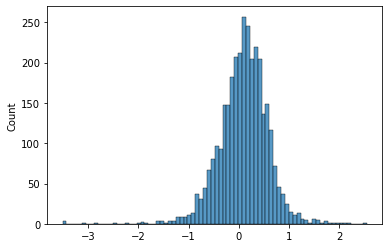

In [186]:
import seaborn as sb

sb.histplot(ite)

In [49]:
cleaned_df.z_all_06.describe()

count    3209.000000
mean        0.041547
std         0.588593
min        -6.785845
25%        -0.247309
50%         0.104151
75%         0.405594
max         2.354861
Name: z_all_06, dtype: float64

NO CONSIDERAR: ite amb counterfactual i observed predits pel model

In [117]:
observed_df=cleaned_df.drop("z_all_06",axis=1)
observed_predict=forest_reg.predict(observed_df)
observed_predict=pd.Series(observed_predict, index=observed_df.index)

In [118]:
ite1=[observed_predict[i]-counterfactuals[i] for i in observed_predict.index if cleaned_df.tr[i]==1]+[counterfactuals[i]-observed_predict[i] for i in observed_predict.index if cleaned_df.tr[i]==0 ]

In [121]:
ite1=pd.Series(ite1, index=cleaned_df.index)
ite1.describe()

count    3209.000000
mean       -0.000477
std         0.036231
min        -0.323135
25%        -0.003446
50%         0.000000
75%         0.008464
max         0.145475
dtype: float64

<AxesSubplot:ylabel='Count'>

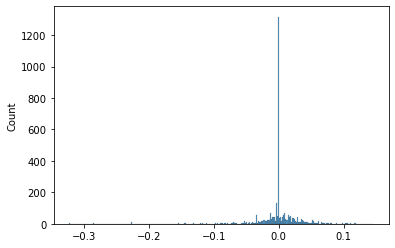

In [123]:
sb.histplot(ite1)

In [124]:
ite1.value_counts()

 0.000000    1193
-0.013396      22
 0.000436      20
-0.034386      19
-0.006040      16
             ... 
-0.018917       1
-0.015859       1
 0.016669       1
-0.010926       1
-0.013396       1
Length: 1295, dtype: int64

### ESTRATIFICACIO ITE

Quartils i std.

1. Separem <=q25, q25<...<=q50, q50<=q75, q75<
2. STD

In [187]:
quartils=ite.quantile([0.25,0.5, 0.75])

In [188]:
ite0=ite[ite<=quartils.iloc[0]]

In [189]:
ite1=ite[ite<=quartils.iloc[1]]
ite1.drop(ite0.index, inplace=True)

In [190]:
ite2=ite[ite<=quartils.iloc[2]]
ite2.drop(ite0.index, inplace=True)
ite2.drop(ite1.index, inplace=True)

In [191]:
ite3=ite.copy()
ite3.drop(ite0.index, inplace=True)
ite3.drop(ite1.index, inplace=True)
ite3.drop(ite2.index, inplace=True)

In [212]:
ite0_df=cleaned_df.loc[ite0.index]
ite1_df=cleaned_df.loc[ite1.index]
ite2_df=cleaned_df.loc[ite2.index]
ite3_df=cleaned_df.loc[ite3.index]

In [249]:
shap=[[stats.shapiro(ite0_df[col].values).pvalue for col in normal_cols],
        [stats.shapiro(ite1_df[col].values).pvalue for col in normal_cols],
        [stats.shapiro(ite2_df[col].values).pvalue for col in normal_cols],
        [stats.shapiro(ite3_df[col].values).pvalue for col in normal_cols]]

shap_df=pd.DataFrame(shap,columns=normal_cols)

In [251]:
#fem el test de shapiro a els subgrups (generats al estratificar la ite en quartils) de les variables normals. 
#Surt normalitat arreu, aixi que si tenen desv std entre ells normals, podrem aplicar t-tests per comprovar 
#si les mitjanes son iguals
shap_df

,height_05,a10whz_05,weight_05,com_haz_05,com_waz_05
0,1.692938e-20,7.999157e-21,5.900706e-23,4.731629e-08,4.332452e-05
1,1.068471e-17,2.055897e-20,1.974264e-18,6.929594e-08,6.752737e-05
2,4.455937e-18,5.056334e-15,9.587839e-20,2.340285e-11,6.823386e-07
3,2.079285e-16,7.975345e-17,1.450469e-14,1.624672e-10,1.016494e-07


In [253]:
std=[[np.std(ite0_df[col].values) for col in normal_cols],
        [np.std(ite1_df[col].values) for col in normal_cols],
        [np.std(ite2_df[col].values) for col in normal_cols],
        [np.std(ite3_df[col].values) for col in normal_cols]]
std_df=pd.DataFrame(std,columns=normal_cols)

In [254]:
std_df

,height_05,a10whz_05,weight_05,com_haz_05,com_waz_05
0,1.051912,0.948997,1.157040,0.535744,0.486789
1,0.973054,0.928258,1.024248,0.515012,0.461553
2,1.022051,0.844274,1.068762,0.521360,0.447696
3,1.241987,0.945313,1.268203,0.524768,0.448712


In [225]:
ite0_df[normal_cols].describe()

,height_05,a10whz_05,weight_05,com_haz_05,com_waz_05
count,803.000000,803.000000,803.000000,803.000000,803.000000
mean,-1.159026,-0.173930,-0.974409,-1.200500,-0.977829
std,1.052567,0.949587,1.157759,0.536077,0.487092
min,-5.587734,-5.823857,-5.136597,-2.323237,-2.374005
25%,-1.548416,-0.527920,-1.452437,-1.537984,-1.321717
50%,-1.213941,-0.169167,-1.013034,-1.204403,-0.987693
75%,-0.806143,0.136461,-0.622533,-0.883109,-0.644499
max,4.332216,4.850458,5.628351,0.504012,0.829595


In [226]:
ite3_df[normal_cols].describe()

,height_05,a10whz_05,weight_05,com_haz_05,com_waz_05
count,802.000000,802.000000,802.000000,802.000000,802.000000
mean,-1.276148,-0.101024,-1.040323,-1.260586,-1.050950
std,1.242762,0.945902,1.268994,0.525096,0.448992
min,-5.690308,-4.034855,-5.669209,-2.323237,-2.374005
25%,-1.717241,-0.479922,-1.570520,-1.737182,-1.397898
50%,-1.213941,-0.169167,-1.013034,-1.252950,-1.062930
75%,-0.762598,0.312019,-0.429225,-0.896829,-0.750683
max,5.101172,3.731095,4.137001,0.504012,0.322270


In [264]:
import scipy
from scipy import stats
    
ttestp_df=[[stats.ttest_ind(ite1_df[col].values, ite0_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite2_df[col].values, ite0_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite3_df[col].values, ite0_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite2_df[col].values, ite1_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite3_df[col].values, ite1_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite3_df[col].values, ite2_df[col].values).pvalue for col in normal_cols]
         ]
ttest_df=pd.DataFrame(ttestp_df,columns=normal_cols, index=["0-1","0-2","0-3","1-2","1-3","2-3"])

In [266]:
#si p<0.05 podem assumir que les mitjanes son diferents (descartem la hipotesi nulla)
ttest_df.style.background_gradient(cmap="Blues")

,height_05,a10whz_05,weight_05,com_haz_05,com_waz_05
0-1,0.058928,0.305725,0.081145,0.620384,0.153247
0-2,0.160772,0.615128,0.654499,0.298979,0.023228
0-3,0.041777,0.123538,0.277192,0.023443,0.001799
1-2,0.644981,0.111466,0.178779,0.577409,0.397782
1-3,0.700412,0.009863,0.610473,0.070128,0.084473
2-3,0.434445,0.261115,0.484147,0.211750,0.370812
